# Data Analysis with Pycaret
In this short tutorial I illustrate a complete data analysis process which exploits the `pycaret` Python library. The documentation of this library can be found at [this link](https://pycaret.org/). The process includes:
* preprocessing, which includes normalization and balancing
* model selection with parameters tuning
* model evaluation
* deployment over unseen data.

## Load Dataset
Firstly, I load the dataset through the Python `pandas` library. I exploit the `heart.csv` dataset, provided by the [Kaggle repository](https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset). This dataset can be exploited to perform binary classification.

In [12]:
import pandas as pd

df = pd.read_csv('source/heart.csv')
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [13]:
df.shape

(303, 14)

## Split data
Now I can split data in data for modeling and unseen data for predictions. Data for modeling will be then split in training and test set, but I will perform this operation later in this tutorial.

Modeling/Unseen splitting is used by means of the `dataframe` function `sample()`, which returns a fraction of random items and receives as input the fraction of items to return (`frac`). In my case, I keep 95% of data for modeling and 5% for unseen.

In [57]:
data = df.sample(frac=0.95, random_state=42)

I calculate `data_unseen` as the remaining dataframe, when the previous extracted data are dropped. 

In [ ]:
data_unseen = df.drop(data.index)

I reset the indexes for both `data` and `data_unseen`.

In [ ]:
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

Finally, I print the size of both the datasets.

In [58]:
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (288, 14)
Unseen Data For Predictions: (15, 14)


## Data Preprocessing
Data Preprocessing is done in `pycaret` through the `setup()` function, which can receive as input an incredible number of parameters. In this tutorial, I exploit three preprocessing techniques:
* **Normalisation**, which scales all the features in the same interval. I exploit the `minmax` function. I dealt with Data Normalisation in my [previous article](https://towardsdatascience.com/data-preprocessing-with-python-pandas-part-3-normalisation-5b5392d27673).
* **Train Test Split**, which splits the dataset into two parts: training and testset. The train set size is 80% of the whole dataset.
* **Balancing**, which tries to balance classes. I try to over sample the minority class. The `pycaret` libray exploits the `imblearn` library, to perform balancing. More details related to the Imbalanced Learn library can be found [here](https://imbalanced-learn.org/stable/). 
 
Before performing balancing I check whether the dataset is balanced or not, i.e. if the output classes in the training set are equally represented. I can use the `value_counts()` function to calculate the number of records in each output class. The output classes are not balanced, thus I can balance them. In this tutorial, I perform over sampling through the `RandomOverSampler()`. 

In [59]:
data['output'].value_counts()

1    155
0    133
Name: output, dtype: int64

The `setup()` function receives as input:
* `normalize = True` and `normalize_method='minmax'`, to specify how to perform normalisation
* `train_size = 0.8` to perform train/test splitting
* `fix_imbalance = True` and `fix_imbalance_method=RandomOverSampler()` to specify how to perform balancing

Additional parameters include:
* `session_id=123`, which is used for reproducibility of the experiment. The value `123` can be a random number
* `data = data`, which specify the model data 
* `target = 'output'`, which specify the target class.

Before running setup, the function asks for confirmation on the automatic recognition of parameters.

In [29]:
from pycaret.classification import *
from imblearn.over_sampling import RandomOverSampler

model = setup(data = data, target = 'output', normalize = True, normalize_method='minmax', train_size = 0.8,fix_imbalance = True, fix_imbalance_method=RandomOverSampler(), session_id=123)

,Description,Value
0,session_id,123
1,Target,output
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(303, 14)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,8
8,Ordinal Features,False
9,High Cardinality Features,False


## Model Selection and Tuning
Model selection can be done in two ways:
* choose a specific model and then tune it
* AutoML: let the library to choose the best model and then tune it.

### Choose the specific model
In this case, I choose a K-Neighbors Classifier. Firstly, I create the model through the `create_model()` function and then I tune it through the `tune_model()` function. It is interesting to note, that the model does not take the data as input, since, they have been already included in `pycaret` through the `setup()` function. As default options, the `tune_model()` performs 10-Fold validation. 

As output the `tune_model()` function prints the following metrics for each fold, as well as the mean value and the standard deviation: accuracy, AUC, Recall, Precision, F1, Kappa, MCC.

In [60]:
knn = create_model('knn')
tuned_knn = tune_model(knn)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8800,0.9675,0.9286,0.8667,0.8966,0.7541,0.7566
1,0.8800,0.9351,0.8571,0.9231,0.8889,0.7588,0.7613
2,0.8750,0.9214,0.9286,0.8667,0.8966,0.7391,0.7419
3,0.7500,0.8571,0.7857,0.7857,0.7857,0.4857,0.4857
4,0.9167,0.9720,1.0000,0.8667,0.9286,0.8298,0.8421
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,0.8750,0.8671,0.9231,0.8571,0.8889,0.7465,0.7492
7,0.7500,0.8322,0.7692,0.7692,0.7692,0.4965,0.4965
8,0.8750,0.9860,0.8462,0.9167,0.8800,0.7500,0.7526
9,0.9167,0.9021,0.9231,0.9231,0.9231,0.8322,0.8322


The `pycaret` library also provides the `plot_model()` function, which permits to plot some metrics, suc as `auc` (ROC curve) and `pr` (precision recall curve).

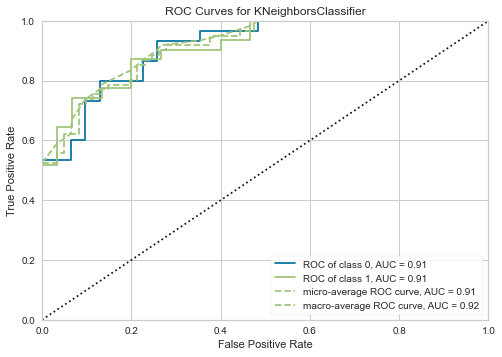

In [62]:
plot_model(tuned_knn, plot = 'auc')

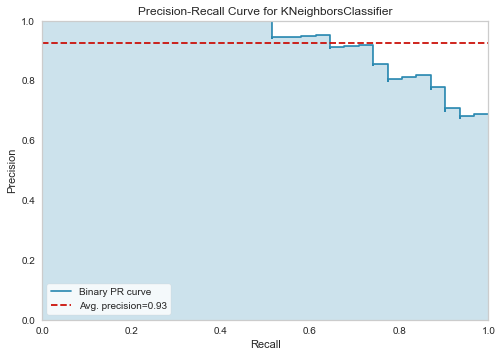

In [64]:
plot_model(tuned_knn, plot = 'pr')

Now I can exploit the tuned model to classify itmes in all the dataset used for modeling (both training and test sets). This can be done through the `predict_model()` function, which returns the calculated metrics. In addition, for each item in the dataset, it returns the original input, the output, the predicted label (column `Label`) and the score (column `Score`).

In [65]:
predict_model(tuned_knn)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.8033,0.9140,0.8065,0.8065,0.8065,0.6065,0.6065


,age,trtbps,chol,thalachh,oldpeak,sex_1,cp_0,cp_1,cp_2,cp_3,...,caa_2,caa_3,caa_4,thall_0,thall_1,thall_2,thall_3,output,Label,Score
0,0.325581,0.367347,0.340183,0.548387,0.035714,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,0.9458
1,0.558140,0.775510,0.226027,0.604839,0.500000,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.9362
2,0.511628,0.367347,0.358447,0.258065,0.285714,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.8852
3,0.465116,0.285714,0.365297,0.362903,0.571429,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0.8758
4,0.255814,0.183673,0.077626,0.540323,0.000000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,0.8765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.441860,0.489796,0.228311,0.322581,0.000000,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0.7763
57,0.581395,0.571429,0.196347,0.693548,0.285714,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,0.9347
58,0.093023,0.265306,0.239726,0.895161,0.678571,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.6821
59,0.767442,0.122449,0.221461,0.572581,0.053571,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,0.7227


### AutoML
AutoML can be done through the `compare_models()` function, which analyses all available models and returns the best model and prints the measured metrics for each tested model.

In [66]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.8842,0.9240,0.9187,0.8810,0.8981,0.7642,0.7685,0.0190
ridge,Ridge Classifier,0.8677,0.0000,0.9115,0.8626,0.8842,0.7301,0.7367,0.0160
rf,Random Forest Classifier,0.8550,0.9143,0.8956,0.8557,0.8731,0.7035,0.7092,0.1680
et,Extra Trees Classifier,0.8508,0.8945,0.8962,0.8516,0.8710,0.6945,0.7009,0.1660
lr,Logistic Regression,0.8468,0.9343,0.8665,0.8629,0.8620,0.6897,0.6958,0.4780
knn,K Neighbors Classifier,0.8430,0.9026,0.8736,0.8534,0.8600,0.6804,0.6882,0.0250
xgboost,Extreme Gradient Boosting,0.8143,0.8939,0.8505,0.8237,0.8326,0.6226,0.6320,0.1000
gbc,Gradient Boosting Classifier,0.8097,0.8787,0.8495,0.8230,0.8292,0.6115,0.6254,0.0720
lightgbm,Light Gradient Boosting Machine,0.7978,0.8967,0.8429,0.8087,0.8199,0.5870,0.5987,0.1160
ada,Ada Boost Classifier,0.7855,0.8801,0.8291,0.8010,0.8101,0.5628,0.5737,0.0730


The best model is:

In [68]:
print(best)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)


Now I can tune the best model through the `tune_model()` function. The process is similar to the one followed for a single model. Thus, after model tuning, I can plot some metrics, such as the precision-recall curve.

In [69]:
tuned_best = tune_model(best)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9200,0.9935,1.0000,0.8750,0.9333,0.8344,0.8461
1,0.8400,0.9221,0.8571,0.8571,0.8571,0.6753,0.6753
2,0.9167,0.9714,0.9286,0.9286,0.9286,0.8286,0.8286
3,0.7917,0.8786,0.8571,0.8000,0.8276,0.5652,0.5674
4,0.9167,0.9650,1.0000,0.8667,0.9286,0.8298,0.8421
5,0.9167,0.9930,0.9231,0.9231,0.9231,0.8322,0.8322
6,0.7917,0.8671,0.9231,0.7500,0.8276,0.5714,0.5913
7,0.7917,0.7692,0.8462,0.7857,0.8148,0.5775,0.5795
8,0.9583,0.9930,1.0000,0.9286,0.9630,0.9155,0.9188
9,0.8750,0.8741,0.9231,0.8571,0.8889,0.7465,0.7492


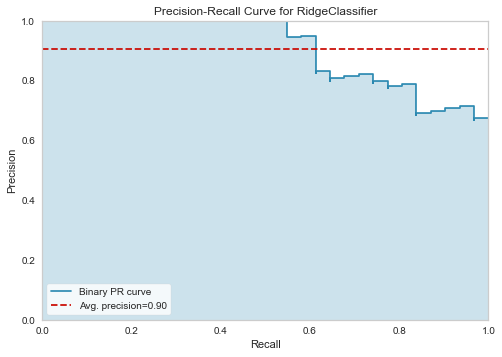

In [70]:
plot_model(tuned, plot = 'pr')

## Finalise the model
Once the model has been tuned, it can be finalised, i.e. re-tuned by also including the test set. 

In [72]:
final_best = finalize_model(tuned_best)

The performance of the finalised model can be checked, firstly, by calling again the `predict_model()` function.

In [55]:
predict_model(final_best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Finally, the performance of the model can be tested on unseen data.

In [73]:
predict_model(final_best, data = data_unseen)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,Label,Score
0,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1,1,0.5792
1,59,1,0,135,234,0,1,161,0,0.5,1,0,3,1,0,0.7500
2,62,1,2,130,231,0,1,146,0,1.8,1,3,3,1,0,0.8962
3,46,1,1,101,197,1,1,156,0,0.0,2,0,3,1,1,0.9575
4,42,1,2,120,240,1,1,194,0,0.8,0,0,3,1,1,0.9180
5,42,1,1,120,295,0,1,162,0,0.0,2,0,2,1,1,0.9805
6,60,1,0,117,230,1,1,160,1,1.4,2,2,3,0,0,0.9776
7,58,1,0,150,270,0,0,111,1,0.8,2,0,3,0,0,0.8864
8,43,0,0,132,341,1,0,136,1,3.0,1,0,3,0,0,0.9009
9,55,1,0,140,217,0,1,111,1,5.6,0,0,3,0,0,0.9776
